In [16]:
import os

os.environ['MKL_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['OMP_NUM_THREADS'] = '1'

import pickle 
import pandas as pd
from d2c.descriptors import D2C, DataLoader
from d2c.benchmark import VARLiNGAM, PCMCI, Granger, DYNOTEARS, D2CWrapper, VAR
from tqdm import tqdm
from d2c.data_generation.utils import show_DAG
import numpy as np

/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import json
import zipfile
import bz2

from multiprocessing import Pool

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from d2c.benchmark import D2CWrapper




In [18]:
dfs = []
root = './descriptors/'
for file in sorted(os.listdir(root)):
    if file.endswith('.pkl'):
        df = pd.read_pickle(root + file)
        dfs.append(df)

training_data = pd.concat(dfs, axis=0).reset_index(drop=True)

columns_d2cfast = [
'coeff_cause',
'coeff_eff',
'm_cau_q6',
'mca_mef_cau_q4', 
'mca_mef_eff_q4',
 'HOC_3_1',
 'kurtosis_ca',
 'kurtosis_ef'
 ]



In [19]:
X_train = training_data.drop(['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal'], axis=1)
X_train = X_train[columns_d2cfast]
y_train = training_data['is_causal']
clf = RandomForestClassifier(n_estimators=25, n_jobs=1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, n_jobs=1)

In [20]:
root = './causeme/'
N_JOBS = 50
for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "0931a3e645e3436b89c56f5e1274dcb7"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'd2c_causal_dfs_{file}.pkl'):

        # Run your method (adapt parameters if needed)
        d2cwrapper = D2CWrapper(ts_list=ts_list, n_variables=n_variables, model=clf, maxlags=maxlags, n_jobs = N_JOBS, full=False)

        d2cwrapper.run()

        causal_dfs = d2cwrapper.get_causal_dfs()

        with open(f'd2c_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'd2c_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs.values():
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['probability']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        #threshold val matrix and do 1 - val_matrix
        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix < 0.35] = 1
        p_matrix[val_matrix >= 0.35] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

Competitors - VAR

In [21]:
root = './causeme/'
N_JOBS = 55

for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "5892502d5b3a441eb0dabdcf04053627"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,'var'+save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'var_causal_dfs_{file}.pkl'):

        var = VAR(ts_list=ts_list, maxlags=maxlags, n_jobs=N_JOBS)
        var.run()
        causal_dfs = var.get_causal_dfs()

        with open(f'var_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'var_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs.values():
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['is_causal']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix == 0] = 1
        p_matrix[val_matrix == 1] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

VARlingam

In [22]:
def complete_causal_df(causal_df, n_variables, maxlags):
    # for VARLiNGAM which randomly misses some couples
    causal_df = causal_df.copy()
    all_pairs = [(from_, to) for from_ in range(n_variables,n_variables * (maxlags + 1)) for to in range(n_variables)]
    
    existing_pairs = set(zip(causal_df['from'], causal_df['to']))
    missing_pairs = [(from_, to) for from_, to in all_pairs if (from_, to) not in existing_pairs]
    
    # Create all missing rows at once if there are any missing pairs
    if missing_pairs:
        missing_rows = pd.DataFrame(missing_pairs, columns=['from', 'to'])
        missing_rows['effect'] = 0.0
        missing_rows['p-value'] = None
        missing_rows['probability'] = 0.0
        missing_rows['is_causal'] = False
        causal_df = pd.concat([causal_df, missing_rows], ignore_index=True)
    
    return causal_df.sort_values(by=['from', 'to']).reset_index(drop=True)

In [23]:
root = './causeme/'
N_JOBS = 50

for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "cf7dff649c80409381d6c757ae12b76e"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,'varlingam'+save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'varlingam_causal_dfs_{file}.pkl'):

        varlingam = VARLiNGAM(ts_list=ts_list, maxlags=maxlags, n_jobs=N_JOBS)
        varlingam.run()
        causal_dfs_varlingam = varlingam.get_causal_dfs()
        
        causal_dfs = [complete_causal_df(causal_df, n_variables,maxlags) for causal_df in causal_dfs_varlingam.values()]

        with open(f'varlingam_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'varlingam_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs:
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['probability']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix == 0] = 1
        p_matrix[val_matrix == 1] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

Dynotears

In [24]:
root = './causeme/'
N_JOBS = 50

for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "4a4ebee6f75e4c29aba7a8f13ac66d39"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,'dynotears'+save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'dynotears_causal_dfs_{file}.pkl'):

        dyno = DYNOTEARS(ts_list=ts_list, maxlags=maxlags, n_jobs=N_JOBS)
        dyno.run()
        causal_dfs = dyno.get_causal_dfs()
        
        with open(f'dynotears_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'dynotears_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs.values():
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['is_causal']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix == 0] = 1
        p_matrix[val_matrix == 1] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

PCMCI

In [25]:
root = './causeme/'
N_JOBS = 50

for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "8cdc476ef289424c9389a83d1a0a16c3"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,'pcmci'+save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'pcmci_causal_dfs_{file}.pkl'):

        pcmci = PCMCI(ts_list=ts_list, maxlags=maxlags, n_jobs=N_JOBS)
        pcmci.run()
        causal_dfs = pcmci.get_causal_dfs()
        
        with open(f'pcmci_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'pcmci_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs.values():
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['is_causal']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix == 0] = 1
        p_matrix[val_matrix == 1] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

Granger

In [26]:
root = './causeme/'
N_JOBS = 50

for file in sorted(os.listdir(root)):
    if not file.endswith('.zip'):
        continue

    results = {}
    results['method_sha'] = "d7e314aaffaf428b912f046eebf77a19"

    maxlags = 5 #general 
    n_variables = int(file.split('N-')[1].split('_')[0])
    results['parameter_values'] = "maxlags=%d" % maxlags
    results['model'] = file.split('_N-')[0]

    experimental_setup = file.split(results['model'])[1].split('.zip')[0][1:]

    results['experiment'] = results['model'] + '_' + experimental_setup

    save_name = '{}_{}_{}'.format('d2cpy',results['parameter_values'], results['experiment'])

    experiment_folder = os.path.join(root,'experiment')
    results_folder = os.path.join(root,'results')
    #create results folder if not exists 
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    unzip_folder = os.path.join(root,'unzip')

    experiment_zip = os.path.join(root,file)
    experiment_results = os.path.join(results_folder,'granger'+save_name+'.json.bz2')

    #################################################

    scores = []
    pvalues = []
    lags = []
    runtimes = []

    results_from_mp = []

    with zipfile.ZipFile(experiment_zip, "r") as zip_ref:
        #unzip the files and make a list
        zip_ref.extractall(unzip_folder)
        names = sorted(zip_ref.namelist())
    
    scores, pvalues, lags, runtimes = [], [], [], []
    
    ts_list = [np.loadtxt(os.path.join(unzip_folder,name)) for name in names]

    # if file 'causal_dfs_{file}.pkl' exists, load it and skip the calculation
    if not os.path.exists(f'granger_causal_dfs_{file}.pkl'):

        granger = Granger(ts_list=ts_list, maxlags=maxlags, n_jobs=N_JOBS)
        granger.run()
        causal_dfs = granger.get_causal_dfs()
        
        with open(f'granger_causal_dfs_{file}.pkl', 'wb') as f:
            pickle.dump(causal_dfs, f)

    else:
        with open(f'granger_causal_dfs_{file}.pkl', 'rb') as f:
            causal_dfs = pickle.load(f)
        
    for causal_df in causal_dfs.values():
        extended_val_matrix = np.zeros((n_variables * (maxlags + 1), n_variables), dtype='float32')
        
        for _, row in causal_df.iterrows():
            source =int(row['from'])
            dest = int(row['to'])
            weight = row['is_causal']
            extended_val_matrix[source, dest] = weight

        val_matrix = np.zeros((n_variables, n_variables), dtype='float32')
        lag_matrix = np.zeros((n_variables, n_variables), dtype='float32')

        for i in range(n_variables):
            for j in range(n_variables):
                values = extended_val_matrix[i::n_variables, j] 
                val_matrix[i, j] = np.max(values)
                lag_matrix[i, j] = np.argmax(values)

        p_matrix = np.zeros_like(val_matrix)
        p_matrix[val_matrix == 0] = 1
        p_matrix[val_matrix == 1] = 0

        # Convert the matrices to the required format and return
        score = val_matrix.flatten()
        pvalue = p_matrix.flatten() if p_matrix is not None else None
        lag = lag_matrix.flatten() if lag_matrix is not None else None

        scores.append(score)
        if pvalue is not None: pvalues.append(pvalue)
        if lag is not None: lags.append(lag)

    results['scores'] = np.array(scores).tolist()
    if len(pvalues) > 0: results['pvalues'] = np.array(pvalues).tolist()
    if len(lags) > 0: results['lags'] = np.array(lags).tolist()
    if len(runtimes) > 0: results['runtimes'] = np.array(runtimes).tolist()

    # Save data
    results_json = bytes(json.dumps(results), encoding='latin1')
    with bz2.BZ2File(experiment_results, 'w') as mybz2:
        mybz2.write(results_json)

    # Empty the folder unzip_folder
    for file in os.listdir(unzip_folder):
        os.remove(os.path.join(unzip_folder,file))

/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constrai

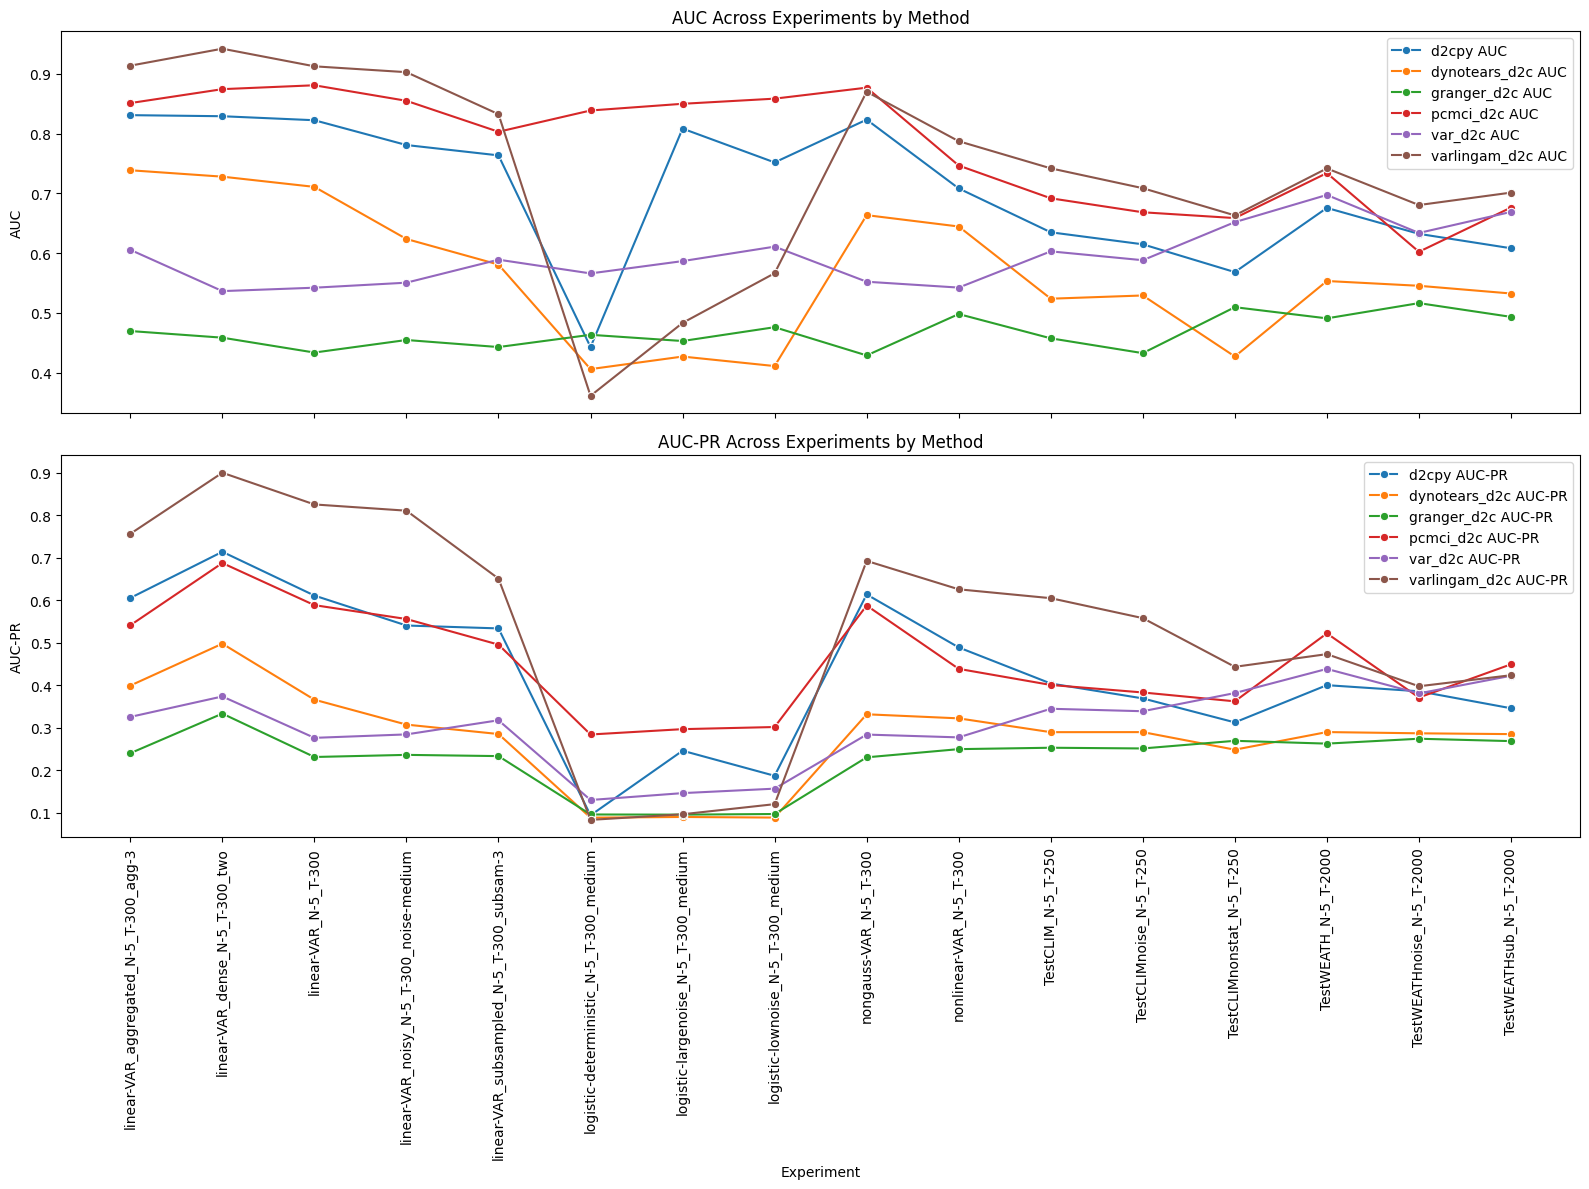

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('./causeme/res.csv')

# Filter out unnecessary columns, focusing only on 'Experiment', 'Method', 'AUC', and 'AUC-PR'
data_filtered = data[['Experiment', 'Method', 'AUC', 'AUC-PR']]

# Create the plots
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot AUC for each method in the first subplot
for method in data_filtered['Method'].unique():
    method_data = data_filtered[data_filtered['Method'] == method]
    sns.lineplot(ax=ax[0], data=method_data, x='Experiment', y='AUC', marker='o', label=f'{method} AUC')
ax[0].set_title('AUC Across Experiments by Method')
ax[0].set_ylabel('AUC')
ax[0].legend()

# Plot AUC-PR for each method in the second subplot
for method in data_filtered['Method'].unique():
    method_data = data_filtered[data_filtered['Method'] == method]
    sns.lineplot(ax=ax[1], data=method_data, x='Experiment', y='AUC-PR', marker='o', label=f'{method} AUC-PR')
ax[1].set_title('AUC-PR Across Experiments by Method')
ax[1].set_ylabel('AUC-PR')
ax[1].legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/tmp/ipykernel_33742/1294596527.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Method'] = data_filtered['Method'].map(name_map)


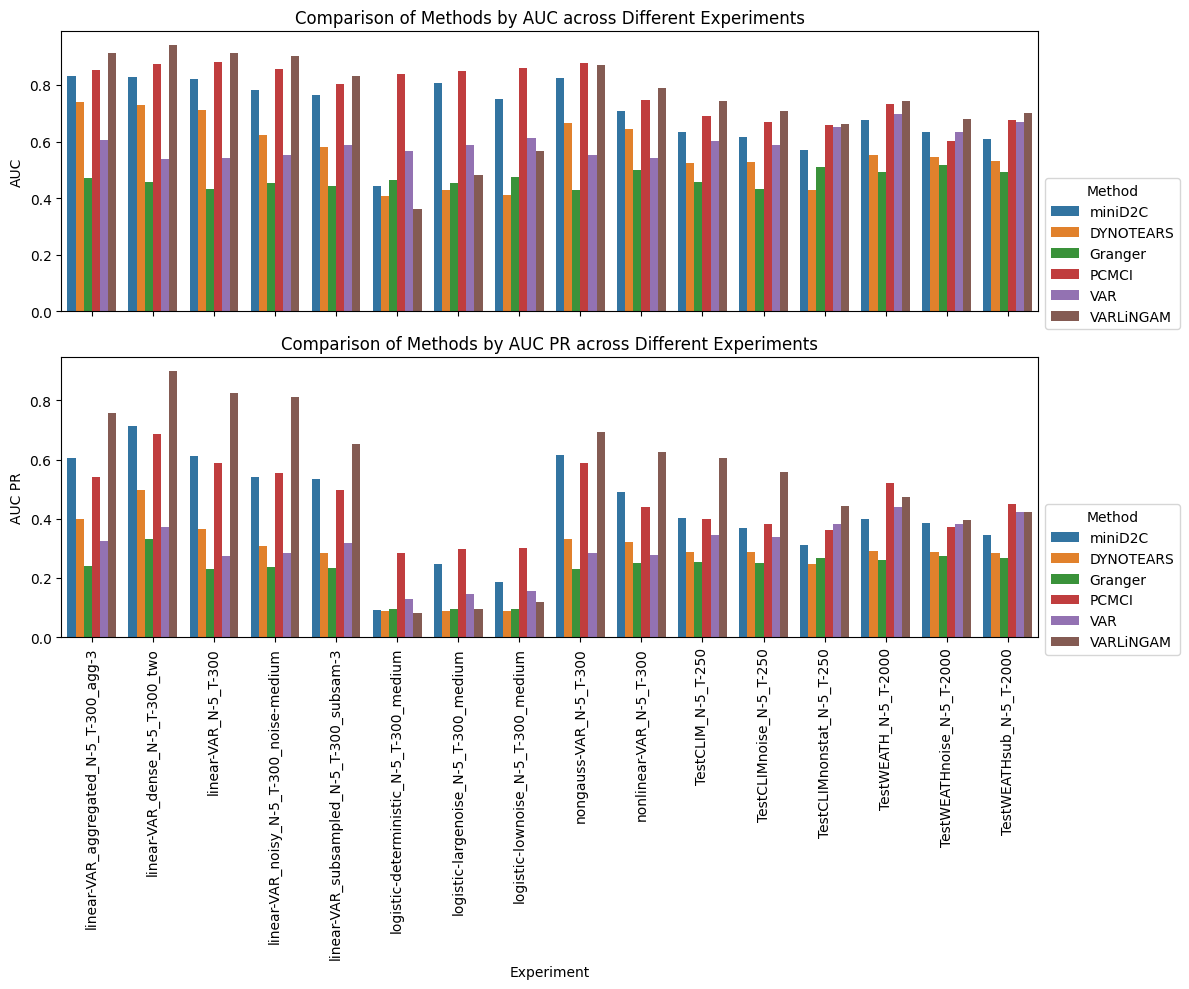

In [28]:
# Adjusting the code to use fig, ax, and share the x-axis

# Load the data
data = pd.read_csv('causeme/res.csv')
# Filter out unnecessary columns, focusing only on 'Experiment', 'Method', 'AUC', and 'AUC-PR'
data_filtered = data[['Experiment', 'Method', 'AUC', 'AUC-PR']]

# Define line styles and markers for clarity in B/W printing
line_styles = ['-', '--', ':', '-.']
markers = ['o', '^', 's', 'D']  # Circle, triangle, square, diamond

name_map = {'d2cpy': 'miniD2C', 'dynotears_d2c': 'DYNOTEARS', 'var_d2c': 'VAR', 'varlingam_d2c': 'VARLiNGAM', 'pcmci_d2c': 'PCMCI', 'granger_d2c': 'Granger'}
# Map method names for display
data_filtered['Method'] = data_filtered['Method'].map(name_map)

# Set up the matplotlib figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Create a bar plot for AUC
sns.barplot(x='Experiment', y='AUC', hue='Method', data=data_filtered, ax=ax1, errorbar='sd')
ax1.set_title('Comparison of Methods by AUC across Different Experiments')
ax1.set_ylabel('AUC')
ax1.set_xlabel('')
ax1.legend(title='Method', loc='upper left', bbox_to_anchor=(1, 0.5))

# Create a bar plot for AUC-PR
sns.barplot(x='Experiment', y='AUC-PR', hue='Method', data=data_filtered, ax=ax2, errorbar='sd')
ax2.set_title('Comparison of Methods by AUC PR across Different Experiments')
ax2.set_ylabel('AUC PR')
ax2.set_xlabel('Experiment')
ax2.legend(title='Method', loc='upper left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent overlap and ensure readability
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
#!zip folder causeme/results
import zipfile
import os

folder_path = "causeme/results"
zip_file_path = "causeme/results.zip"

# Create a zip file
with zipfile.ZipFile(zip_file_path, "w") as zip_ref:
    # Iterate over all files in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Get the full path of the file
            file_path = os.path.join(root, file)
            # Add the file to the zip file
            zip_ref.write(file_path, os.path.relpath(file_path, folder_path))


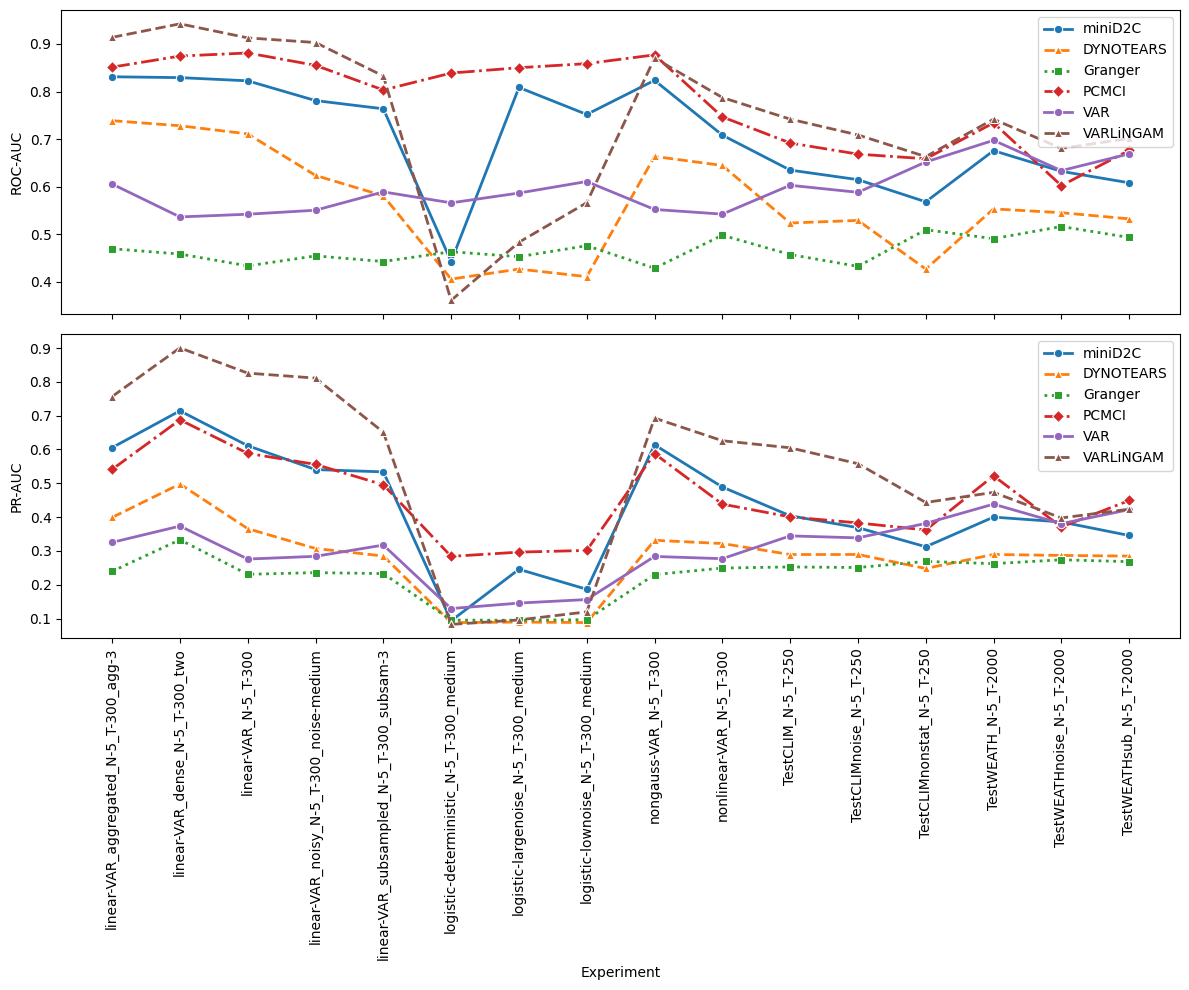

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out unnecessary columns, focusing only on 'Experiment', 'Method', 'AUC', and 'AUC-PR'
data_filtered = data[['Experiment', 'Method', 'AUC', 'AUC-PR']]

# Define line styles and markers for clarity in B/W printing
line_styles = ['-', '--', ':', '-.']
markers = ['o', '^', 's', 'D']  # Circle, triangle, square, diamond

name_map = {'d2cpy':'miniD2C', 'dynotears_d2c':'DYNOTEARS', 'var_d2c':'VAR', 'varlingam_d2c':'VARLiNGAM', 'pcmci_d2c':'PCMCI', 'granger_d2c':'Granger'}
# Create the plots
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Iterate through each method to plot with unique style
for idx, method in enumerate(data_filtered['Method'].unique()):
    style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    method_data = data_filtered[data_filtered['Method'] == method]
    sns.lineplot(ax=ax[0], data=method_data, x='Experiment', y='AUC', marker=marker, linestyle=style, label=f'{name_map[method]}', linewidth=2)
    sns.lineplot(ax=ax[1], data=method_data, x='Experiment', y='AUC-PR', marker=marker, linestyle=style, label=f'{name_map[method]}', linewidth=2)

# ax[0].set_title('AUC Across Experiments by Method')
ax[0].set_ylabel('ROC-AUC')
ax[0].legend()

# ax[1].set_title('AUC-PR Across Experiments by Method')
ax[1].set_ylabel('PR-AUC')
ax[1].legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [25]:
for exp in data_filtered['Experiment'].unique():
    print(exp)

linear-VAR_aggregated_N-5_T-300_agg-3
linear-VAR_dense_N-5_T-300_two
linear-VAR_N-5_T-300
linear-VAR_noisy_N-5_T-300_noise-medium
linear-VAR_subsampled_N-5_T-300_subsam-3
logistic-deterministic_N-5_T-300_medium
logistic-largenoise_N-5_T-300_medium
logistic-lownoise_N-5_T-300_medium
nongauss-VAR_N-5_T-300
nonlinear-VAR_N-5_T-300
TestCLIM_N-5_T-250
TestCLIMnoise_N-5_T-250
TestCLIMnonstat_N-5_T-250
TestWEATH_N-5_T-2000
TestWEATHnoise_N-5_T-2000
TestWEATHsub_N-5_T-2000
